<a href="https://colab.research.google.com/github/ayfeng23/FB_algorithms/blob/main/Silver_Stepsize_FB_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code adapted from https://github.com/mzydiao/FBGVI/blob/main/FBGVI-Experiments.ipynb.

In [ ]:
#@title Packages
# math
import numpy as np
from numpy.random import multivariate_normal as mvn
from scipy.stats import ortho_group, uniform, bernoulli
from scipy.linalg import sqrtm
from scipy.optimize import minimize

# plotting/visualization
import matplotlib.pyplot as plt
from cycler import cycler
from jax import hessian

# python utils
from functools import partial

In [ ]:
#@title Matrix Generation from Eigs

def gen_matrix_with_eigs(eigs):
    """
    Generates a symmetric matrix with eigenvalues `eigs`.
    """
    dim = len(eigs)
    x = ortho_group.rvs(dim)
    return x.T @ np.diag(eigs) @ x

def gen_matrix_with_eigbounds(low, high, dim: int):
    """
    Generates a symmetric matrix with eigenvalues within [low, high].
    """
    eigs = low + (high - low) * uniform.rvs(size=dim)
    return gen_matrix_with_eigs(eigs)

def clip_matrix(M: np.array, upper):
    """
    Assuming that M is PSD, return the matrix obtained by clipping the singular values at upper.
    """
    eigs = np.linalg.eig(M)
    return eigs[1] @ np.diag(np.minimum(eigs[0], upper)) @ eigs[1].T

In [ ]:
#@title Distance Functions
def wasserstein_dist(mu_0, mu_1, Sigma_0, Sigma_1):
    """
    Return the squared W2 distance between N(mu_0, Sigma_0), N(mu_1, Sigma_1).
    """
    half_0 = sqrtm(Sigma_0)
    half_1 = sqrtm(Sigma_1)
    return np.sum((mu_0 - mu_1) ** 2) + np.sum((half_0 - half_1) ** 2)

epsilon = 1e-6
def H(mu, Sigma):
    """
    Return the negentropy of N(mu, Sigma).
    """
    d = len(mu)
    assert d == Sigma.shape[0] and d == Sigma.shape[1]
    return -(
        d/2 * (1 + np.log(2 * np.pi))
        + 1/2 * np.log(np.linalg.det(Sigma))
    )

def kl_divergence(mu_0, mu_1, Sigma_0, Sigma_1):
    """
    Return the KL divergence
    KL( N(mu_0, Sigma_0) || N(mu_1, Sigma_1) ).
    """
    d = mu_0.shape[0]

    det_0 = np.linalg.det(Sigma_0)
    det_1 = np.linalg.det(Sigma_1)
    Sigma_1_inv = np.linalg.inv(Sigma_1)
    div = np.log(det_1) - np.log(det_0)
    div -= d
    div += (Sigma_1_inv * Sigma_0).sum()
    div += (mu_1 - mu_0).T @ Sigma_1_inv @ (mu_1 - mu_0)
    div /= 2
    return div

In [ ]:
def softmax(x):
    """
    Univariate softmax function.
    """
    return np.exp(x) / (1 + np.exp(x))

In [63]:
#@title Experiment Class
import math
class Experiment():
    """
    Parent class for experiments.
    Implements BWGD and FBGVI and plots results.
    """

    def __init__(
        self,
        log_potential,
        gradient_oracle,
        dist_objective,
        dist_objective_name = r"$\mathcal{F}(p_k)$",
        dim = 5, beta = 1,
        grad_V = None,
        hess_V = None,
        Sigma_true = None
    ):
        """
        Initialize parameters of experiment:
        - params: dim, beta
        - log_potential
            * takes in a vector x and produces the unnormalized log potential.
        - dist_objective
            * (mu, Sigma) -> objective function to plot
            * by default, we can make this equal to EE_p V - H(p)
        - gradient_oracle
            * (mu, Sigma) -> estimate for (EE nabla V, EE nabla^2 V)
            * default:
                > draw x ~ N(mu, Sigma)
                > compute v = V(x)
                > v.backward()
                > x.grad
        - initialize Sigma_0 at isotropic Gaussian
        """

        self.log_potential = log_potential
        self.gradient_oracle = gradient_oracle
        self.dist_objective = dist_objective
        self.dist_objective_name = dist_objective_name
        self.dim = dim
        self.grad_V = grad_V
        self.hess_V = hess_V
        self.Sigma_true = Sigma_true
        print(self.Sigma_true)

        # initialize mean with all zeros
        self.init_mu = np.zeros(dim)

        # initialize Sigma at identity
        self.init_Sigma = np.eye(dim) / beta

    def laplace_approx(self):
        """
        Compute Laplace approximation to target distribution.
        """
        if self.hess_V is None:
            raise NotImplementedError

        x0 = np.zeros(self.dim)

        # compute MAP
        result = minimize(
            self.log_potential,
            x0,
            jac = self.grad_V,
            hess = self.hess_V
        )
        mu = result.x

        # compute Hessian at map
        H = self.hess_V(mu)

        # compute inverse of Hessian to obtain Sigma
        Sigma = np.linalg.inv(H + epsilon * np.eye(self.dim))

        return mu, Sigma

    def is_symmetric(self, matrix, iternum, matrix_name):
        if not np.array_equal(matrix, matrix.T):
          print(matrix_name + " " + str(iternum) + " is not symmetric")
          trunc_matrix = np.trunc(matrix * 100) / 100
          print(trunc_matrix)
          print("\n\n")

    def is_psd_short(self, matrix, iternum, matrix_name):
        eigenvalues = np.linalg.eigvals(matrix)
        if not bool(np.all(eigenvalues >= 0)):
            self.is_psd_long(matrix, iternum, matrix_name)

    def is_psd_long(self, matrix, iternum, matrix_name):
        eigenvalues = np.linalg.eigvals(matrix)
        print(matrix_name + " " + str(iternum) +" : " + str(bool(np.all(eigenvalues >= 0))))
        print("Min Eig " + matrix_name + " " + str(iternum) + " " + str(min(eigenvalues)))
        print("\n\n")

    def make_symmetric(self, matrix):
        upper_triangle = np.triu(matrix)
        symmetric_matrix = upper_triangle + upper_triangle.T - np.diag(upper_triangle.diagonal())
        return symmetric_matrix

    def compute_condition_number(self, matrix, matrix_name, iternum):
        try:
            # Ensure matrix is symmetric
            matrix = self.make_symmetric(matrix)

            # Compute eigenvalues
            eigenvalues = np.linalg.eigvals(matrix)
            max_eig = np.max(np.abs(eigenvalues))
            min_eig = np.min(np.abs(eigenvalues))

            # Compute condition number
            condition_number = max_eig / (min_eig + 1e-10)  # Add small constant to avoid division by zero

            print(f"Condition number of {matrix_name} at iteration {iternum}: {condition_number:.2e}")
            print(f"Max eigenvalue: {max_eig:.2e}")
            print(f"Min eigenvalue: {min_eig:.2e}\n")

            return condition_number
        except np.linalg.LinAlgError:
            print(f"Failed to compute condition number for {matrix_name} at iteration {iternum}")
            return float('inf')

    def v2(self, n):
        if n == 0:
            return float('inf')  # Convention: v_2(0) is infinite
        count = 0
        while n % 2 == 0:
            n //= 2
            count += 1
        return count

    rho = 1 + math.sqrt(2)
    def stepsize(self, n, rho=rho):
        return 1 + rho ** (self.v2(n+1) + 1)

    def is_power_of_two(self, n):
        return n > 0 and bin(n).count('1') == 1

    def run_iter(self, alg, eta, mu, Sigma, iternum = 1):
        """
        Run an iteration of the specified algorithm to update (mu, Sigma).
        Returns new (mu, Sigma).
        """
        hat_nabla1, hat_nabla2 = self.gradient_oracle(mu, Sigma)
        r = 3
        tau = iternum / (iternum + r)

        # compute gradient in mu
        # (update is the same between BWGD and FBGVI)
        # grad_mu = self.Sigma_true_inv @ (mu - self.mu_true)
        mu = mu - eta * hat_nabla1
        mu_copy = mu.copy()

        # Sigma_inv = np.linalg.inv(self.Sigma_true)
        # eigenvalues = np.linalg.eigvalsh(Sigma_inv)
        # L = np.max(eigenvalues)
        # print(L)

        if alg == "bwgd":
            # compute gradient in Sigma
            M = np.eye(self.dim) - eta * (hat_nabla2 - np.linalg.inv(Sigma))
            Sigma = M @ Sigma @ M

            mean = mu
            Cov = Sigma

        elif alg == "fbgvi":
            # do forward step for the energy
            M_half = np.eye(self.dim) - eta * hat_nabla2
            Sigma_half = M_half @ Sigma @ M_half

            # do backward step for the entropy

            sqrt_matrix = sqrtm(
                Sigma_half @ (Sigma_half + 4 * eta * np.eye(self.dim))
            )
            sqrt_matrix = np.real(sqrt_matrix)
            Sigma = 0.5 * (Sigma_half + 2 * eta * np.eye(self.dim) + sqrt_matrix)

            mean = mu
            Cov = Sigma

        elif alg == "silverfb":
            print(self.stepsize(iternum))
            ############### EDIT THIS ##################
            #silver_stepsize = self.stepsize(iternum) / L
            #silver_stepsize = self.stepsize(iternum) * 0.01 / L
            #silver_stepsize = self.stepsize(iternum) * 0.01
            silver_stepsize = self.stepsize(iternum) * 2
            ############################################

            M_half = np.eye(self.dim) - silver_stepsize * hat_nabla2
            Sigma_half = M_half @ Sigma @ M_half

            sqrt_matrix = sqrtm(
                Sigma_half @ (Sigma_half + 4 * silver_stepsize * np.eye(self.dim))
            )
            sqrt_matrix = np.real(sqrt_matrix)
            Sigma = 0.5 * (Sigma_half + 2 * silver_stepsize * np.eye(self.dim) + sqrt_matrix)

            mean = mu
            Cov = Sigma

        else:
            raise NotImplementedError

         #probably unnecessary

        return mu, Sigma

    def run_experiment(
        self,
        iters_list = 10000, time = 10000,
        init_mu = None, init_Sigma = None,
        plot_laplace = False
    ):
        """
        Run both BWGD and FBGVI and Silver FBGVI.
        """
        alg_dists = []
        time_axes = []
        if init_mu is None:
            init_mu = self.init_mu
        if init_Sigma is None:
            init_Sigma = self.init_Sigma

        for iters in iters_list:
            print(iters)
            step_size_multiple = 1
            eta = time / (step_size_multiple * iters)
            gd_mu_k, gd_Sigma_k = init_mu, init_Sigma
            prox_mu_k, prox_Sigma_k = init_mu, init_Sigma
            silver_mu_k, silver_Sigma_k = init_mu, init_Sigma

            gd_dists = [self.dist_objective(gd_mu_k, gd_Sigma_k)]
            prox_dists = [self.dist_objective(prox_mu_k, prox_Sigma_k)]
            silver_dists = [self.dist_objective(silver_mu_k, silver_Sigma_k)]
            powers_of_two = [0]

            for k in range(iters):
                try:
                    new_mu, new_Sigma = (
                        self.run_iter("bwgd", eta, gd_mu_k, gd_Sigma_k)
                    )
                    gd_mu_k, gd_Sigma_k = new_mu, new_Sigma
                    gd_dists.append(self.dist_objective(gd_mu_k, gd_Sigma_k))
                except np.linalg.LinAlgError:
                    still_psd = False
                    print("np linalg error from trying to sample from MVN!")
                    gd_dists.append(gd_dists[-1])
            for k in range(iters):
                new_mu, new_Sigma = self.run_iter("fbgvi", eta, prox_mu_k, prox_Sigma_k)
                prox_mu_k, prox_Sigma_k = new_mu, new_Sigma
                prox_dists.append(self.dist_objective(prox_mu_k, prox_Sigma_k))
            for k in range(iters):
                new_mu, new_Sigma = self.run_iter("silverfb", eta, silver_mu_k, silver_Sigma_k, iternum = k)
                silver_mu_k, silver_Sigma_k = new_mu, new_Sigma
                silver_dists_k = self.dist_objective(silver_mu_k, silver_Sigma_k)
                if self.is_power_of_two(k + 2):
                    silver_dists.append(silver_dists_k)
                    powers_of_two.append(k)
                # silver_dists.append(silver_dists_k)
                # powers_of_two.append(k)
                print("Silver FBGVI Distance " + str(k + 1) + " : "+ str(silver_dists_k) )
                print("\n")

            alg_dists += [
                (fr'BWGD, $\eta = {eta:.3f}$', gd_dists),
                (fr'FBGVI, $\eta = {eta:.3f}$', prox_dists),
                (fr'Silver FBGVI, $\eta = {eta:.3f}$', silver_dists)
            ]
            time_axis_powers_of_two = np.array(powers_of_two) * (time / iters)
            time_axes += [
                np.linspace(0, time, iters+1),
                np.linspace(0, time, iters+1),
                time_axis_powers_of_two
            ]
            print("Len Time: ", len(time_axis_powers_of_two))
            print("Len Algs: ", len(silver_dists))
        self.plot_results(
            time_axes, alg_dists, plot_laplace = plot_laplace
        )

    def plot_results(
        self, time_axes, alg_dists, ax = None, plot_laplace = False
    ):
        """
        Plot distances and label results for all the algorithms of interest.
        """

        # configure plot

        plt.title(fr"{self.dist_objective_name} over iterations")
        plt.xlabel(r"time elapsed ($\eta \times \# $iters)")
        plt.ylabel(self.dist_objective_name)

        fig = plt.gcf()
        fig.set_size_inches(8, 5)
        fig.set_dpi(160)

        if ax is None:
            ax = plt.gca()
        ax.set_prop_cycle(
            cycler('color', list(plt.rcParams["axes.prop_cycle"].by_key()["color"])) *
            cycler('linestyle', ['-', '--', ':'])
        )

        for time, (alg_name, dists) in zip(time_axes, alg_dists):
            """
            Plot distances and label results for particular algorithm of interest.
            """
            dists = np.array(dists)
            ax.plot(time, dists, label = alg_name, linewidth=0.8)
        if plot_laplace:
            # draw laplace approximation error
            laplace_mu, laplace_Sigma = self.laplace_approx()
            ax.axhline(
                self.dist_objective(laplace_mu, laplace_Sigma),
                label="Laplace approx"
            )

        plt.legend()
        plt.show()

In [ ]:

class GaussianExperiment(Experiment):
    """
    Run convergence experiment for different algorithms on randomly generated target.
    """

    def __init__(
        self, dim = 5, alpha = 0.01, beta = 1,
        stochastic = False,
        W2 = False
    ):
        """
        Initialize parameters of experiment:
        - dim, alpha
        - true (mu, Sigma) and precomputed Sigma^{-1}
        - nabla V(x)
        - initial Sigma for experiments
        """

        """
        define potential
        V = 1/2 (x - mu) Sigma^-1 (x - mu)
        """
        def log_potential(x, mu, Sigma_inv):
            assert x.shape[0] == mu.shape[0]
            first = x.T - mu
            second = np.dot(Sigma_inv, (x.T - mu).T)
            return 1/2 * np.dot(
                first,
                second
            )

        # randomly initialize mu, Sigma
        mu_true = uniform.rvs(size = (dim, ))
        Sigma_true = gen_matrix_with_eigs(
            np.geomspace(1/beta, 1/alpha, dim)
        )
        Sigma_true_inv = np.linalg.inv(Sigma_true)

        log_potential_pure = partial(
            log_potential, mu = mu_true, Sigma_inv = Sigma_true_inv
        )

        if not stochastic:
            def gradient_oracle(mu, Sigma):
                nabla_1 = Sigma_true_inv @ (mu - mu_true)
                nabla_2 = Sigma_true_inv
                return nabla_1, nabla_2
        else:
            def gradient_oracle(mu, Sigma):
                x = mvn(mu, Sigma)
                nabla_1 = Sigma_true_inv @ (x - mu_true)
                nabla_2 = Sigma_true_inv
                return nabla_1, nabla_2

        if W2:
            # distance objective is the W2 distance
            def dist_objective(mu, Sigma):
                return np.log(wasserstein_dist(mu, mu_true, Sigma, Sigma_true))
        else:
            # distance objective is the KL divergence to target
            def dist_objective(mu, Sigma):
                return np.log(kl_divergence(mu, mu_true, Sigma, Sigma_true))
        super().__init__(
            log_potential_pure,
            gradient_oracle,
            dist_objective,
            dist_objective_name = (
                r"$\log W_2^2(p_k, \hat{{\pi}})$" if W2 else
                r"$\log \mathsf{KL}(p_k \Vert \hat{\pi})$"
            ),
            dim = dim,
            Sigma_true = Sigma_true
        )

Streaming output truncated to the last 5000 lines.
Silver FBGVI Distance 7193 : 6.3017400029686295


0.9999999999999977
6.82842712474619
Silver FBGVI Distance 7194 : 6.261674130882411


0.9999999999999977
3.414213562373095
Silver FBGVI Distance 7195 : 6.241989598295745


0.9999999999999977
15.071067811865474
Silver FBGVI Distance 7196 : 6.154848243875412


0.9999999999999977
3.414213562373095
Silver FBGVI Distance 7197 : 6.135926671810165


0.9999999999999977
6.82842712474619
Silver FBGVI Distance 7198 : 6.098240650741108


0.9999999999999977
3.414213562373095
Silver FBGVI Distance 7199 : 6.079711239225495


0.9999999999999977
198.9949493661166
Silver FBGVI Distance 7200 : 4.960171795325123


0.9999999999999977
3.414213562373095
Silver FBGVI Distance 7201 : 4.94815724928708


0.9999999999999977
6.82842712474619
Silver FBGVI Distance 7202 : 4.924382894688252


0.9999999999999977
3.414213562373095
Silver FBGVI Distance 7203 : 4.912727045246321


0.9999999999999977
15.071067811865474
Silv

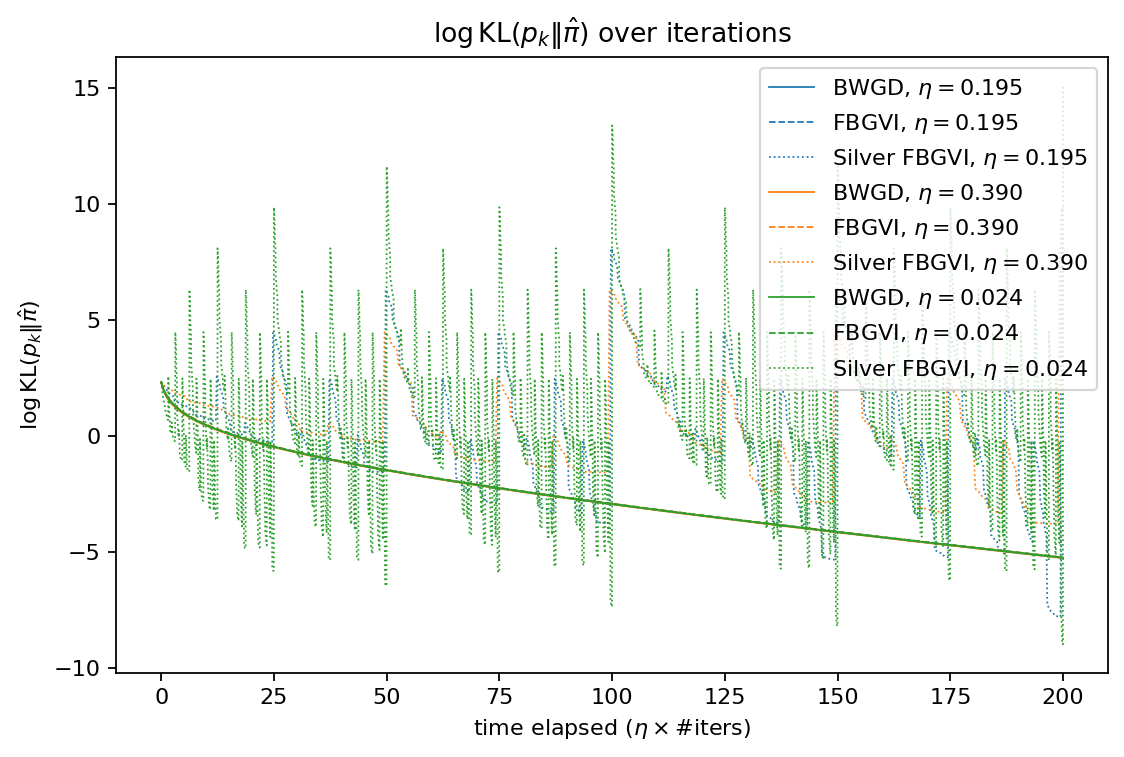

In [ ]:
alpha_choice = 5e-3
exp = GaussianExperiment(dim = 10, alpha = alpha_choice, stochastic = False)
exp.run_experiment(iters_list = [1025, 513, 8192], time = 200) #time and num_iters both affect step size

#You have different graphs of Silver Stepsize FBGVI as the graph condenses or expands with different number of iterations
#? When we have a large number of iterations, we seem to get worse performance, might be a bug?

Streaming output truncated to the last 5000 lines.
Silver FBGVI Distance 7193 : 6.301740439241144


0.9999999999999998
6.82842712474619
Silver FBGVI Distance 7194 : 6.261674584931834


0.9999999999999998
3.414213562373095
Silver FBGVI Distance 7195 : 6.241990061312687


0.9999999999999998
15.071067811865474
Silver FBGVI Distance 7196 : 6.1548487489863115


0.9999999999999998
3.414213562373095
Silver FBGVI Distance 7197 : 6.135927186504182


0.9999999999999998
6.82842712474619
Silver FBGVI Distance 7198 : 6.0982411851341185


0.9999999999999998
3.414213562373095
Silver FBGVI Distance 7199 : 6.079711783543599


0.9999999999999998
198.9949493661166
Silver FBGVI Distance 7200 : 4.960173462599775


0.9999999999999998
3.414213562373095
Silver FBGVI Distance 7201 : 4.948158936499546


0.9999999999999998
6.82842712474619
Silver FBGVI Distance 7202 : 4.924384622273955


0.9999999999999998
3.414213562373095
Silver FBGVI Distance 7203 : 4.912728792863941


0.9999999999999998
15.071067811865474
Si

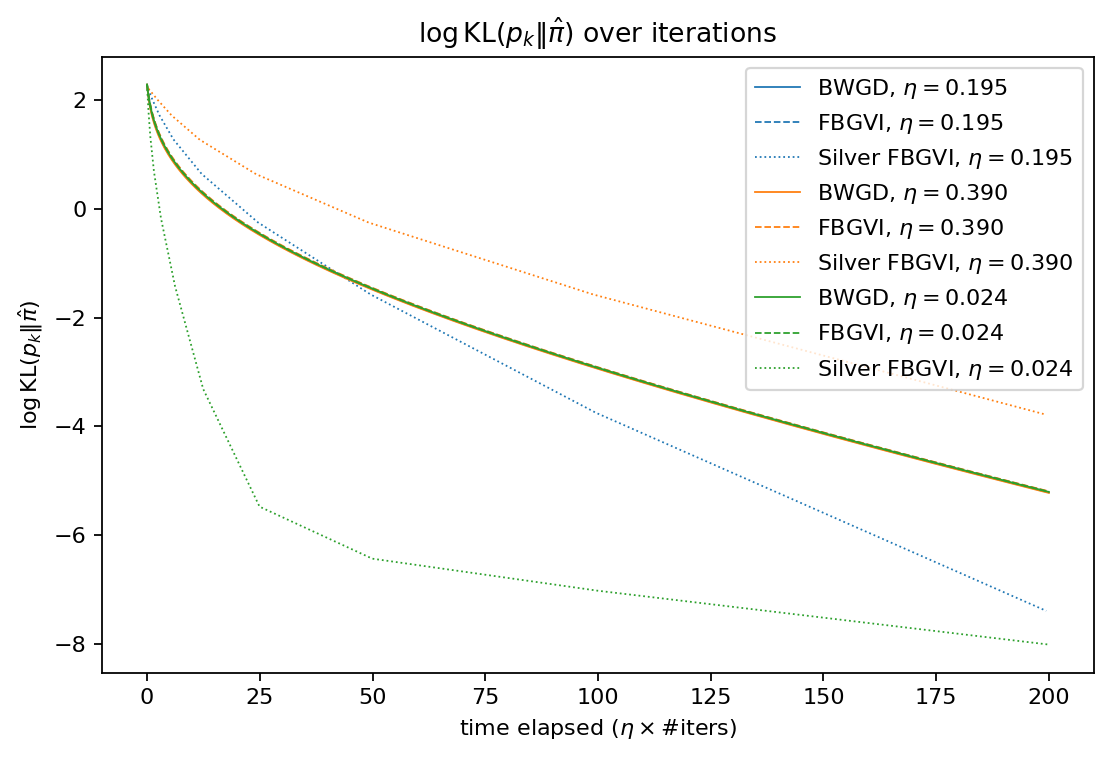

In [ ]:
alpha_choice = 5e-3
exp = GaussianExperiment(dim = 10, alpha = alpha_choice, stochastic = False)
exp.run_experiment(iters_list = [1025, 513, 8192], time = 200) #time and num_iters both affect step size

#You have different graphs of Silver Stepsize FBGVI as the graph condenses or expands with different number of iterations
#? When we have a large number of iterations, we seem to get worse performance, might be a bug?

Streaming output truncated to the last 5000 lines.
Silver FBGVI Distance 7193 : 6.383018659404682


0.9999999999999976
6.82842712474619
Silver FBGVI Distance 7194 : 6.332794158788424


0.9999999999999976
3.414213562373095
Silver FBGVI Distance 7195 : 6.311464413401908


0.9999999999999976
15.071067811865474
Silver FBGVI Distance 7196 : 6.224544966005441


0.9999999999999976
3.414213562373095
Silver FBGVI Distance 7197 : 6.202527574754217


0.9999999999999976
6.82842712474619
Silver FBGVI Distance 7198 : 6.161356115985054


0.9999999999999976
3.414213562373095
Silver FBGVI Distance 7199 : 6.135782538737613


0.9999999999999976
198.9949493661166
Silver FBGVI Distance 7200 : 5.126574027418872


0.9999999999999976
3.414213562373095
Silver FBGVI Distance 7201 : 5.106313064497127


0.9999999999999976
6.82842712474619
Silver FBGVI Distance 7202 : 5.071384116907298


0.9999999999999976
3.414213562373095
Silver FBGVI Distance 7203 : 5.050266328060692


0.9999999999999976
15.071067811865474
Silv

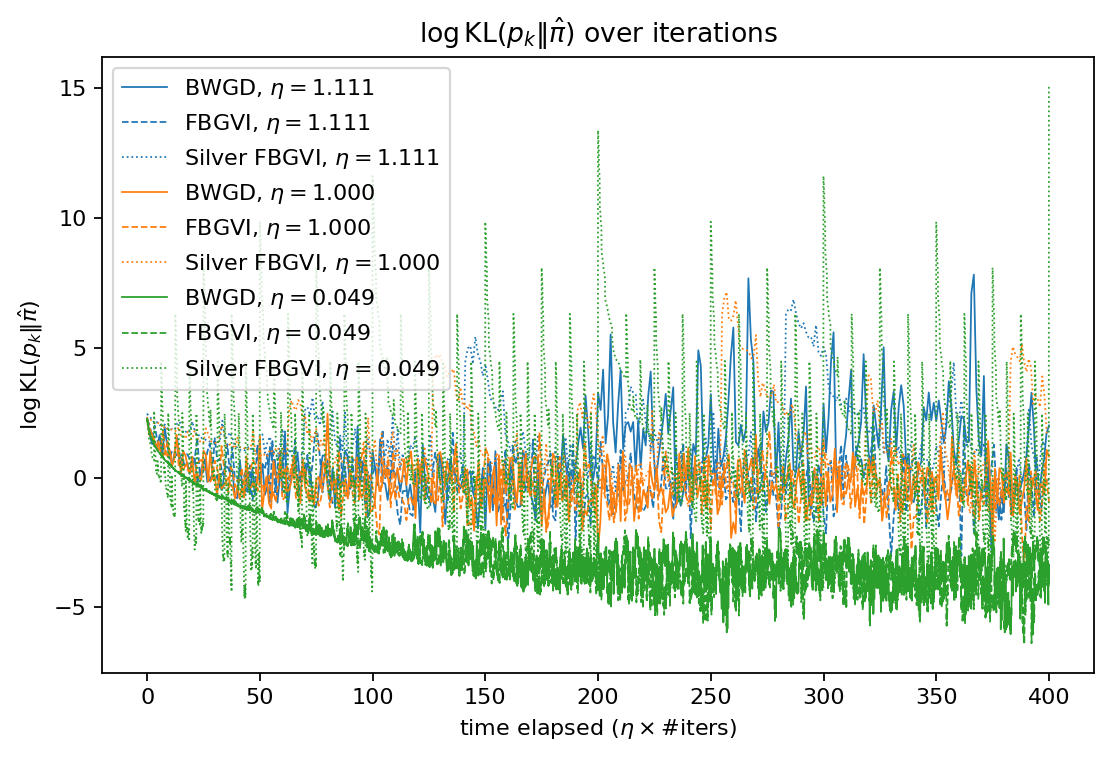

In [ ]:
exp = GaussianExperiment(dim = 10, alpha = alpha_choice, stochastic = True)
exp.run_experiment(iters_list = [360, 400, 8192], time = 400)

360
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.9999999999999962
0.999999

<ipython-input-52-dc35ed6df094>:50: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x = mvn(mu, Sigma)


Streaming output truncated to the last 5000 lines.
Silver FBGVI Distance 7193 : 6.328515401840103


0.9999999999999962
6.82842712474619
Silver FBGVI Distance 7194 : 6.287914893667737


0.9999999999999962
3.414213562373095
Silver FBGVI Distance 7195 : 6.26801929515486


0.9999999999999962
15.071067811865474
Silver FBGVI Distance 7196 : 6.176882993318603


0.9999999999999962
3.414213562373095
Silver FBGVI Distance 7197 : 6.1576712019696025


0.9999999999999962
6.82842712474619
Silver FBGVI Distance 7198 : 6.118391187589421


0.9999999999999962
3.414213562373095
Silver FBGVI Distance 7199 : 6.102127174079237


0.9999999999999962
198.9949493661166
Silver FBGVI Distance 7200 : 5.0247261029521


0.9999999999999962
3.414213562373095
Silver FBGVI Distance 7201 : 5.009273465442659


0.9999999999999962
6.82842712474619
Silver FBGVI Distance 7202 : 4.986968490250869


0.9999999999999962
3.414213562373095
Silver FBGVI Distance 7203 : 4.974412378255712


0.9999999999999962
15.071067811865474
Silver

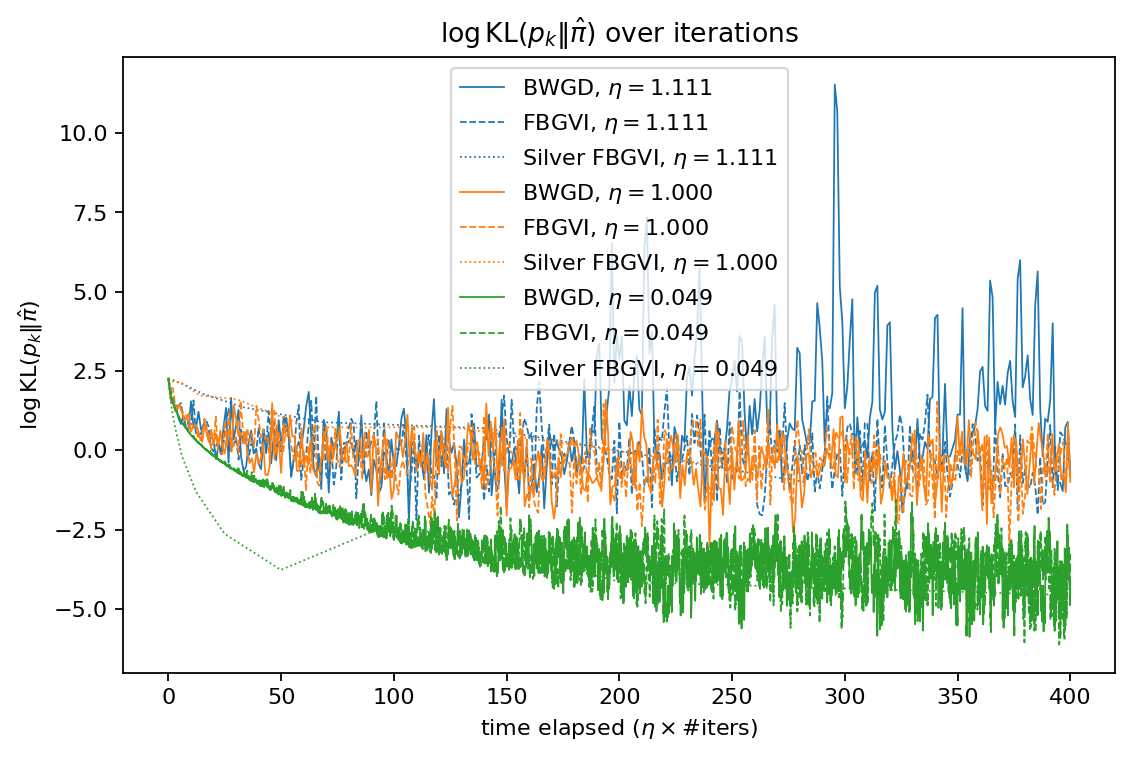

In [ ]:
exp = GaussianExperiment(dim = 10, alpha = alpha_choice, stochastic = True)
exp.run_experiment(iters_list = [360, 400, 8192], time = 400)

In [ ]:
#@title Logistic Regression
class LogisticRegressionExperiment(Experiment):
    """
    Bayesian logistic regression posterior as target.
    """

    def __init__(
        self, dim = 5, n = 20,
        TOTAL_SAMPLES = 1000,
        FI = False
    ):
        """
        Parameters:
        - dim: dimension of theta
        - n: number of samples from generative model
        - TOTAL_SAMPLES:
            total number of samples used to approximate KL divergence
        """
        """
        Define the log potental, gradient, Hessian.
        """
        def log_potential(theta, Y, X):
            """
            Compute log potential.
            V(theta) = sum_{i=1}^n
                (-Y_i <theta, X_i> + ln(1 + exp <theta, X_i>)).
            """
            first = np.log(1 + np.exp(np.dot(X, theta))).sum(axis=0)
            second = np.dot(Y, np.dot(X, theta))
            return first - second

        def grad_V(theta, Y, X):
            """
            Compute gradient of log potential.
            nabla V(theta) = -sum_{i=1}^n
                (Y_i - softmax(<theta, X_i>)) X_i.
            """
            first = Y - softmax(np.dot(X, theta)).T
            second = -np.dot(first, X)
            return second.T

        def hess_V(theta, Y, X):
            """
            Compute the Hessian of the log potential.
            nabla^2 V(theta) = sum_{i=1}^n
                (exp <theta, X_i>) / (1 + exp <theta, X_i>)^2 X_i X_i^T
            """
            first = (
                softmax(np.dot(X, theta)) /
                (1 + np.exp(np.dot(X, theta)))
            )
            second = X.T @ np.diag(first) @ X
            return second

        """
        Data generation
        """
        # generate true parameter theta
        true_theta = mvn(np.zeros(dim), np.eye(dim))

        # generate random data matrix X
        X = mvn(
            np.zeros(dim),
            np.eye(dim),
            size=(n)
        )

        maxeig = np.linalg.eig(X.T @ X)[0][0]
        X = X / np.sqrt(maxeig)

        # from generative model, draw observations Y
        probs = softmax(X @ true_theta)
        Y = bernoulli.rvs(probs)

        # Define log_potential as a pure function of theta
        log_potential_pure = partial(log_potential, Y = Y, X = X)
        grad_pure = partial(grad_V, Y = Y, X = X)
        hess_pure = partial(hess_V, Y = Y, X = X)

        def gradient_oracle(mu, Sigma):
            theta = mvn(mu, Sigma)
            return grad_pure(theta), hess_pure(theta)

        if FI:
            # use empirical BW fisher info as distance objective.
            def dist_objective(mu, Sigma):
                """
                Compute the empirical log Fisher information as a distance objective.
                """
                Sigma_inv = np.linalg.inv(Sigma)

                # draw random samples from N(mu, Sigma) to approximate EE||nabla_BW F||^2.
                x = mvn(mu, Sigma, size = TOTAL_SAMPLES).T

                # grad_log = grad_pure(x) - np.dot(Sigma_inv, (x.T - mu).T)
                # assert grad_log.shape
                # return np.log((grad_log ** 2).sum(axis=0).mean())

                grad_stack = grad_pure(x)
                # should be (TOTAL_SAMPLES, dim)
                expected_grad = grad_stack.mean(axis=0)

                # compute expected hessian by integration by parts.
                expected_hess = 1/2 * (np.dot(grad_stack, (x.T - mu))) / TOTAL_SAMPLES
                expected_hess = expected_hess @ Sigma_inv
                # enforce symmetric
                expected_hess = expected_hess + expected_hess.T

                bw_grad = expected_grad + np.dot(x.T - mu, expected_hess).T - np.dot(x.T - mu, Sigma_inv).T
                return np.log((bw_grad ** 2).sum(axis=0).mean())
        else:
            # use empirical KL divergence to unnormalized target.
            def dist_objective(mu, Sigma):
                """
                Compute the empirical KL divergence
                to the unnormalized target as a distance objective.
                """
                # draw random samples from N(mu, Sigma) to approximate F(p_k).
                theta = mvn(mu, Sigma, size = TOTAL_SAMPLES).T

                # compute empirical expectation of V
                log_potentials = log_potential_pure(theta)
                assert log_potentials.shape == (TOTAL_SAMPLES, )
                EE_V = log_potentials.mean()
                return EE_V + H(mu, Sigma)

        super().__init__(
            log_potential_pure,
            gradient_oracle,
            dist_objective,
            dist_objective_name = (
                r"$\log \hat\mathbb{E}_{p_k} \Vert \nabla_{BW} \mathcal{F}(p_k) \Vert^2$"
                if FI else
                r"$\mathcal{F}(p_k)$ (empirical)"
            ),
            dim = dim,
            grad_V = grad_pure,
            hess_V = hess_pure
        )

Streaming output truncated to the last 5000 lines.


479.0020920410529
Silver FBGVI Distance 2752 : 0.17640826207093246


3.414213562373095
Silver FBGVI Distance 2753 : 0.28112717310236934


6.82842712474619
Silver FBGVI Distance 2754 : 0.10561629615178855


3.414213562373095
Silver FBGVI Distance 2755 : 0.2814352590230997


15.071067811865474
Silver FBGVI Distance 2756 : 0.1669438336942504


3.414213562373095
Silver FBGVI Distance 2757 : 0.2663750059477896


6.82842712474619
Silver FBGVI Distance 2758 : 0.186146106332969


3.414213562373095
Silver FBGVI Distance 2759 : 0.30131078582368886


34.970562748477136
Silver FBGVI Distance 2760 : 0.08152387649708345


3.414213562373095
Silver FBGVI Distance 2761 : 0.1250434271827028


6.82842712474619
Silver FBGVI Distance 2762 : 0.14156574753512727


3.414213562373095
Silver FBGVI Distance 2763 : 0.20269574831796744


15.071067811865474
Silver FBGVI Distance 2764 : 0.12596115619466253


3.414213562373095
Silver FBGVI Distance 2765 : 0.0817958

<ipython-input-56-f5415faf8b37>:64: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  result = minimize(


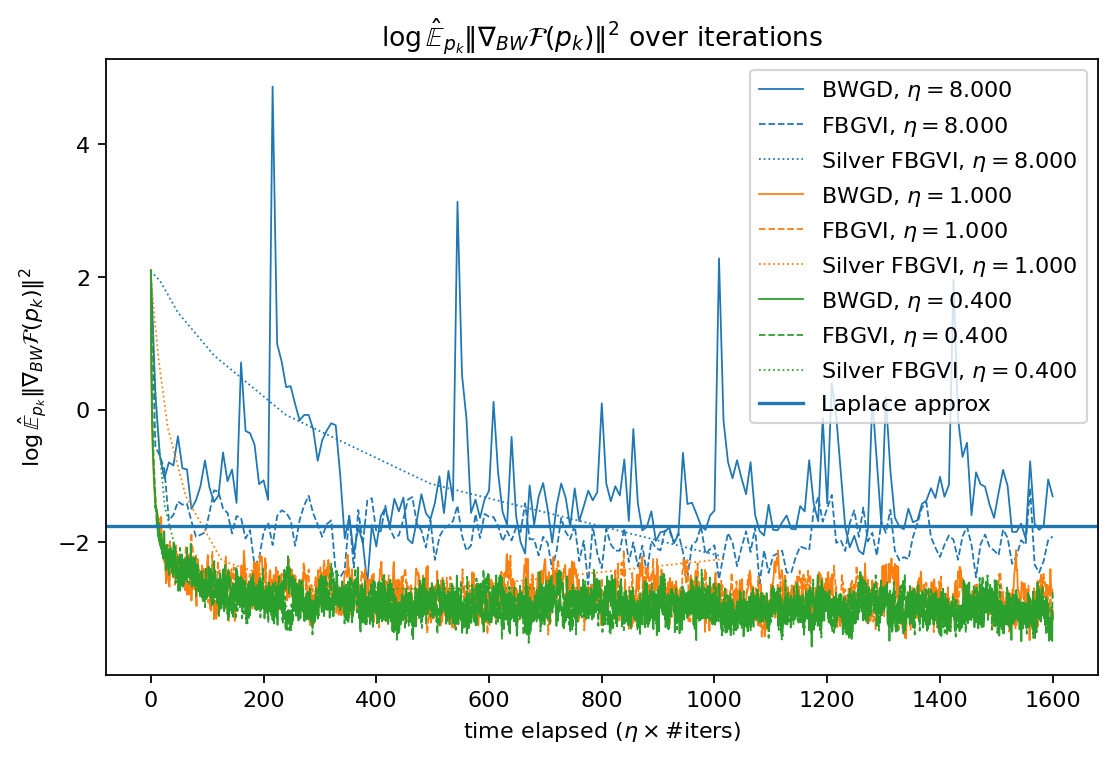

In [60]:
exp = LogisticRegressionExperiment(dim = 10, FI = True)
exp.run_experiment(
    iters_list = [200, 1600, 4000], time = 1600, plot_laplace = True
)

Streaming output truncated to the last 5000 lines.


6.82842712474619
Silver FBGVI Distance 802 : -0.008856829072959163


3.414213562373095
Silver FBGVI Distance 803 : 0.08245329327256637


15.071067811865474
Silver FBGVI Distance 804 : 0.0408417773452587


3.414213562373095
Silver FBGVI Distance 805 : -0.09255814083091835


6.82842712474619
Silver FBGVI Distance 806 : -0.11974692734597965


3.414213562373095
Silver FBGVI Distance 807 : -0.08616080839495702


34.970562748477136
Silver FBGVI Distance 808 : -0.20030608848494763


3.414213562373095
Silver FBGVI Distance 809 : -0.09516139071707208


6.82842712474619
Silver FBGVI Distance 810 : -0.00956743801829071


3.414213562373095
Silver FBGVI Distance 811 : -0.12263624030801053


15.071067811865474
Silver FBGVI Distance 812 : -0.10202830497830116


3.414213562373095
Silver FBGVI Distance 813 : -0.16780233927899452


6.82842712474619
Silver FBGVI Distance 814 : -0.09272959054508263


3.414213562373095
Silver FBGVI Distance 815 : -0.0692

<ipython-input-56-f5415faf8b37>:64: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  result = minimize(


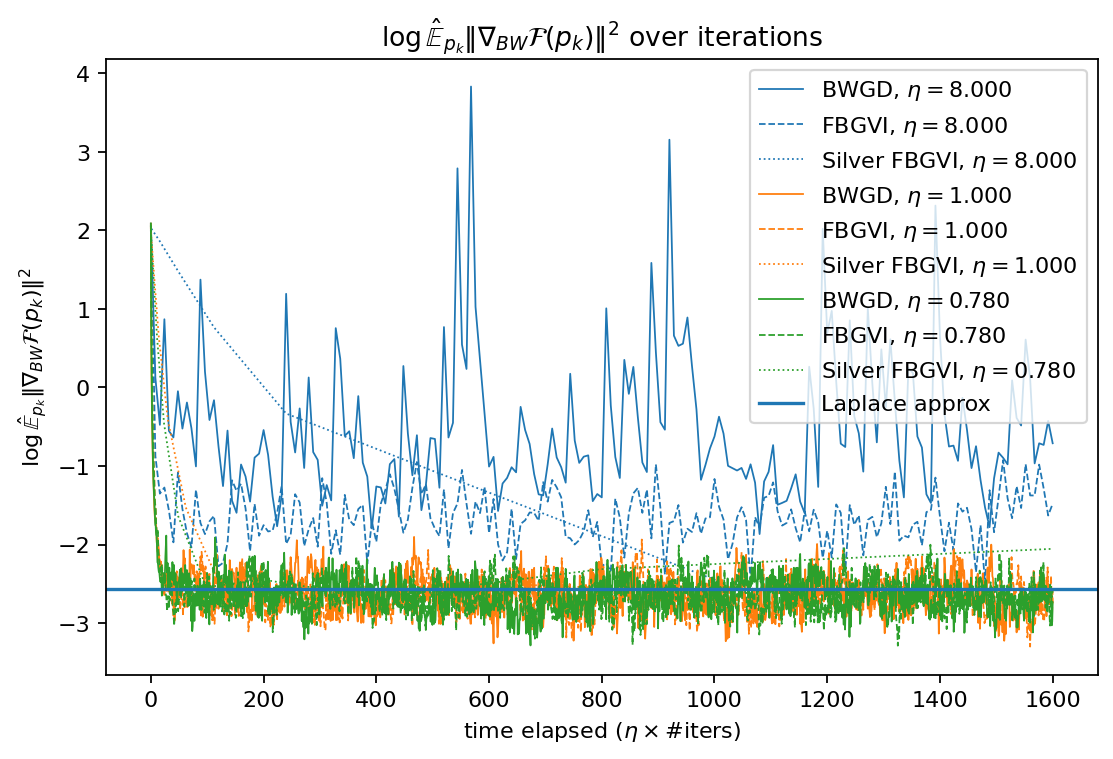

In [64]:
exp = LogisticRegressionExperiment(dim = 10, FI = True)
exp.run_experiment(
    iters_list = [200, 1600, 2050], time = 1600, plot_laplace = True
)